<a href="https://colab.research.google.com/github/tfysekis/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Domain Selection and Dataset Creation

In this project, we will conduct sentiment analysis using the Amazon Fine Food Reviews dataset. This dataset contains over 500,000 customer reviews of food products available on Amazon, making it a rich resource for analyzing customer opinions. Each review includes both the text of the review and a numerical rating (1–5), which we will use to classify sentiment into three categories:

- Positive: Ratings of 4 or 5
- Neutral: A rating of 3
- Negative: Ratings of 1 or 2

## Load the Dataset

In [ ]:
import pandas as pd  # Library for working with data

# Try to load the dataset
try:
    # Reads the uploaded file into a pandas DataFrame
    df = pd.read_csv('Reviews.csv', encoding='utf-8')

    # Show the first 5 rows
    print(df.head())

    # Display the total number of rows
    print("Total number of rows in the dataset:", df.shape[0])

except FileNotFoundError:
    print("The file was not found. Check if the file is uploaded correctly and the name is typed correctly.")
except Exception as e:
    print("An error occurred:", e)


   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

## Data Preprocessing: Streamlining and Subsetting the Review Dataset


In this step, we streamline the dataset to make it more manageable for model training by:

1. **Removing Non-Essential Columns**: Excluding metadata and identifier columns (e.g., user IDs, timestamps, etc.) that do not contribute directly to the sentiment analysis process. This ensures the focus remains on the review text and sentiment score, which are critical for our analysis.

2. **Subsetting the Dataset**: Retaining only a portion (20%) of the original dataset. This step reduces memory usage and accelerates training time without significantly impacting the quality of our results.

---

### **Why Use 20% of the Dataset?**

- The original dataset is extremely large, which can lead to increased memory consumption and prolonged training times. This can be particularly challenging when working with resource-intensive models like DistilBERT.
- By keeping 20% of the data, we still retain a substantial amount of reviews for analysis. This ensures the model has enough diverse data to learn from while avoiding potential resource constraints during training.
- Subsetting the dataset strikes a balance between computational efficiency and maintaining robust model performance.


In [ ]:
import pandas as pd

# Specify the percentage of data to retain
subset_percentage = 0.2  # 20% of the dataset

# Columns to keep
columns_to_keep = ['Score', 'Text']

# Reduce the DataFrame to essential columns
df_reduced = df[columns_to_keep]

# Subset the dataset to the specified percentage
df_reduced = df_reduced.sample(frac=subset_percentage, random_state=42)

# Check the reduced dataset structure
print("Total rows after reducing the dataset to 20%:", df_reduced.shape[0])
print(df_reduced.head())


Total rows after reducing the dataset to 20%: 113691
        Score                                               Text
165256      5  Having tried a couple of other brands of glute...
231465      5  My cat loves these treats. If ever I can't fin...
427827      3  A little less than I expected.  It tends to ha...
433954      2  First there was Frosted Mini-Wheats, in origin...
70260       5  and I want to congratulate the graphic artist ...


## Check the Data

Data Integrity Check: This step involves checking for missing values in each column of the dataset to ensure data integrity. Missing values can impact model performance, so identifying and addressing them is crucial for reliable analysis and accurate predictions.

In [ ]:
# Check for missing values in each column
missing_values = df_reduced.isnull().sum()

# Display the count of missing values for each column
print(missing_values)

Score    0
Text     0
dtype: int64


## **Transform Ratings into Sentiment Categories**

Now, it's finally time to transform the numerical ratings into sentiment categories to prepare the data for analysis. The transformation is as follows:
- **Positive**: Ratings of 4 or 5.
- **Neutral**: A rating of 3.
- **Negative**: Ratings of 1 or 2.

This categorization simplifies the analysis by converting numerical ratings into meaningful sentiment labels, which will serve as the target variable for our sentiment analysis models.

In [ ]:
# Explicitly create a copy of the reduced DataFrame
df_transformed= df_reduced[columns_to_keep].copy()

# Function to categorize ratings
def categorize_rating(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Apply function to the 'Score' column
df_transformed['Sentiment'] = df_transformed['Score'].apply(categorize_rating)

# Print the first 10 rows to see the original scores and their corresponding sentiments
print(df_transformed[['Score', 'Sentiment', 'Text']].head(10))
print("Total rows after cleaning:", df_transformed.shape[0])


        Score Sentiment                                               Text
165256      5  Positive  Having tried a couple of other brands of glute...
231465      5  Positive  My cat loves these treats. If ever I can't fin...
427827      3   Neutral  A little less than I expected.  It tends to ha...
433954      2  Negative  First there was Frosted Mini-Wheats, in origin...
70260       5  Positive  and I want to congratulate the graphic artist ...
49866       4  Positive  Please add more Pineapple flavor to your packa...
551047      5  Positive  I absolutely love Yorkshire tea and am so glad...
18983       5  Positive  I have such a hard time finding loose tea loca...
138968      4  Positive  Previously, I've attempted a recipe with white...
36352       5  Positive  I make pancakes or waffles every Saturday morn...
Total rows after cleaning: 113691


## Text Length Analysis: Insights into Review Characteristics

To gain a deeper understanding of the dataset, we analyzed the length of the review text. By calculating the number of characters in each review, we obtained key statistics such as the average, minimum, and maximum text lengths.

This information is useful for understanding the nature of the dataset and guiding preprocessing decisions:
- Extremely short reviews might lack context and could be considered for removal to avoid noise.
- Very long reviews may require truncation to fit within the input limits of certain models, especially transformers like BERT.
- The overall distribution of text lengths provides insights into the complexity and variability of user feedback in the dataset.

These findings ensure that the dataset is well-prepared for subsequent analysis and modeling steps.

In [ ]:
# Calculate the text length for each review
df_transformed['Text_Length'] = df_transformed['Text'].apply(len)

# Get basic statistics about text lengths
text_length_stats = df_transformed['Text_Length'].describe()

# Display the statistics
print(text_length_stats)


count    113691.000000
mean        436.305679
std         445.510483
min          30.000000
25%         179.000000
50%         301.000000
75%         528.000000
max       11321.000000
Name: Text_Length, dtype: float64


# 2. Preprocessing and Text Analysis

## Comprehensive Text Cleaning and Preprocessing

This section of the code is designed to clean and preprocess the text data from your dataset. It involves several steps that prepare the text for further NLP tasks such as sentiment analysis. The cleaning function will remove HTML tags, URLs, special characters, convert text to lowercase, and remove stopwords. We apply this function to both the Summary and Text columns to ensure they are uniformly cleaned.

In [ ]:
# Import necessary libraries
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

# Download necessary NLTK resources
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define a comprehensive cleaning function
def clean_and_preprocess(text):
    # Check if the input contains HTML tags and remove them
    if '<' in text and '>' in text:
        text = BeautifulSoup(text, "lxml").get_text()

    # Remove URLs and special characters
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Special characters

    # Convert text to lowercase
    text = text.lower().strip()

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Apply the cleaning function to the dataset
df_transformed['Cleaned_Text'] = df_transformed['Text'].apply(clean_and_preprocess)

# Display the cleaned text to verify
print(df_transformed[['Text', 'Cleaned_Text']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thwma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                     Text  \
165256  Having tried a couple of other brands of glute...   
231465  My cat loves these treats. If ever I can't fin...   
427827  A little less than I expected.  It tends to ha...   
433954  First there was Frosted Mini-Wheats, in origin...   
70260   and I want to congratulate the graphic artist ...   

                                             Cleaned_Text  
165256  tried couple brands glutenfree sandwich cookie...  
231465  cat loves treats ever cant find house pop top ...  
427827  little less expected tends muddy taste expecte...  
433954  first frosted miniwheats original size frosted...  
70260   want congratulate graphic artist putting entir...  


## Handling Contractions for Improved Text Consistency

Contractions, such as "can't" or "it's," are common in textual data and can create inconsistencies during text processing. Expanding these contractions into their full forms (e.g., "cannot," "it is") improves text standardization and ensures that words carry their full semantic meaning.

For this task, we utilized the contractions library, a Python package that efficiently handles contraction expansion. By applying this step, we transformed the text to a more uniform structure, which is particularly beneficial for tokenization and vectorization in later stages.

This preprocessing step is independent of other cleaning processes, allowing flexibility in the pipeline while ensuring the dataset is ready for downstream analysis.

In [ ]:
!pip install contractions
import contractions

# Define a function to expand contractions
def expand_contractions(text):
    """
    Expands contractions in the given text.
    Example: "can't" -> "cannot", "it's" -> "it is"
    """
    return contractions.fix(text)

# Apply the contractions expansion function to the dataset
df_transformed['Expanded_Text'] = df_transformed['Cleaned_Text'].apply(expand_contractions)

# Display the expanded text to verify
print(df_transformed[['Text', 'Expanded_Text']].head())


                                                     Text  \
165256  Having tried a couple of other brands of glute...   
231465  My cat loves these treats. If ever I can't fin...   
427827  A little less than I expected.  It tends to ha...   
433954  First there was Frosted Mini-Wheats, in origin...   
70260   and I want to congratulate the graphic artist ...   

                                            Expanded_Text  
165256  tried couple brands glutenfree sandwich cookie...  
231465  cat loves treats ever cannot find house pop to...  
427827  little less expected tends muddy taste expecte...  
433954  first frosted miniwheats original size frosted...  
70260   want congratulate graphic artist putting entir...  


# 3. Baseline Model Development

In this task, we'll:

1. Split the dataset into training and testing sets using a 70-30 split.
Vectorize the Cleaned_Text column using TF-IDF to prepare it for machine learning models.
2. Train and evaluate two baseline models:
3. Logistic Regression: A simple, effective classifier.
4. Support Vector Machine (SVM): Known for its robustness in text classification.
5. Compare their performance using metrics like accuracy, precision, recall, and F1 score.

## Data Splitting

**Data Splitting: Preparing Training and Testing Sets**

In this step, we split the dataset into training and testing sets to evaluate model performance. Here's how the split is structured:

- **Features**: The `Expanded_Text` column, containing the preprocessed review text, serves as the input for the model.
- **Target**: The `Sentiment` column, containing sentiment labels (Positive, Neutral, Negative), is the prediction target.

We use a **70-30 split**, where:
- **70%** of the data is allocated for training the model (`X_train`, `y_train`).
- **30%** is reserved for testing and evaluating the model (`X_test`, `y_test`).

This ensures the model is trained on a majority of the data while maintaining a separate dataset for unbiased evaluation.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
X = df_transformed['Expanded_Text']  # Feature: Expanded_Text
y = df_transformed['Sentiment']     # Target: Sentiment

# Train-test split (70-30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 79583
Testing set size: 34108


## Text Vectorization with TF-IDF

In this step, we use **TF-IDF (Term Frequency-Inverse Document Frequency)** vectorization to transform the textual data into numerical features for machine learning models. This method ensures the model focuses on the most meaningful words and phrases, reducing the influence of commonly used terms.

### TF-IDF Vectorizer Configuration:
- **Feature Limitation**: The number of features is capped at **5000**, ensuring efficiency while retaining the most informative terms.
- **N-Grams**: Captures both **unigrams** (single words) and **bigrams** (two-word phrases) for richer contextual understanding.
- **Frequency Thresholds**:
  - Terms appearing in more than **95% of documents** are excluded to avoid overly common words.
  - Terms appearing in fewer than **2 documents** are excluded as they provide little value.

### Process:
1. **Fit and Transform Training Data**:
   - The TF-IDF vectorizer learns the vocabulary from the training data and converts it into numerical features (`X_train_tfidf`).
2. **Transform Testing Data**:
   - The same vocabulary is applied to the testing data (`X_test_tfidf`) to ensure consistency during evaluation.

### Output:
- The transformed datasets are stored as sparse matrices:
  - **`X_train_tfidf`**: Contains the numerical features for the training set.
  - **`X_test_tfidf`**: Contains the numerical features for the testing set.
- The dimensions of these matrices are displayed, confirming the number of samples and features.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer with improved parameters
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), max_df=0.95, min_df=2)

# Fit and transform training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Display results
print(f"TF-IDF vectorization complete with {X_train_tfidf.shape[1]} features.")
print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Testing data shape: {X_test_tfidf.shape}")

# Display sample features from the vocabulary
top_features = tfidf_vectorizer.get_feature_names_out()[:10]
print("Sample features from TF-IDF vocabulary:", top_features)


TF-IDF vectorization complete with 5000 features.
Training data shape: (79583, 5000)
Testing data shape: (34108, 5000)
Sample features from TF-IDF vocabulary: ['ability' 'able' 'able buy' 'able find' 'able get' 'absolute'
 'absolute favorite' 'absolutely' 'absolutely delicious' 'absolutely love']


## **Logistic Regression for Sentiment Analysis**

In this step, we train a **Logistic Regression model** to classify sentiments (Positive, Neutral, Negative) using the TF-IDF-transformed text data. Logistic Regression is a widely used classification algorithm due to its simplicity and effectiveness, making it an excellent choice for our baseline model.

#### **Process**:
1. **Training**:
   - The model is trained on the TF-IDF-transformed training data (`X_train_tfidf`) using the corresponding sentiment labels (`y_train`).
   - To address potential class imbalances in the dataset, the model is initialized with `class_weight="balanced"`, ensuring that each sentiment class is given equal importance during training.

2. **Prediction**:
   - The trained model predicts sentiment labels for the test data (`X_test_tfidf`).

3. **Evaluation**:
   - A **classification report** provides metrics such as:
     - **Precision**: How many of the predicted sentiments were correct.
     - **Recall**: How many of the actual sentiments were correctly identified.
     - **F1-Score**: The harmonic mean of precision and recall, providing a balanced metric.
   - A **confusion matrix** visualizes the model's performance by comparing the actual and predicted sentiment labels.

4. **Confusion Matrix Visualization**:
   - The confusion matrix is displayed as a heatmap for better interpretability, highlighting where the model performs well and where misclassifications occur.

#### **Why Logistic Regression?**
- Logistic Regression is computationally efficient and interpretable, making it ideal for establishing a baseline performance.
- It helps identify patterns in the TF-IDF-transformed data, enabling us to assess the relationship between textual features and sentiment labels.

By the end of this step:
- We have a trained Logistic Regression model that provides sentiment predictions.
- The evaluation metrics, including the confusion matrix and classification report, offer insights into the model's performance and areas for improvement.

This baseline model serves as a foundation for comparing more advanced techniques in future steps.

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    Negative       0.60      0.71      0.65      4931
     Neutral       0.25      0.57      0.35      2625
    Positive       0.96      0.81      0.88     26552

    accuracy                           0.78     34108
   macro avg       0.60      0.70      0.63     34108
weighted avg       0.85      0.78      0.80     34108

Confusion Matrix:
[[ 3521  1040   370]
 [  597  1500   528]
 [ 1761  3351 21440]]


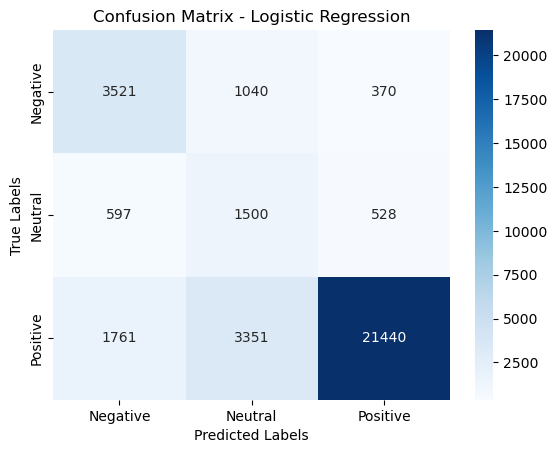

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train Logistic Regression model with class balancing
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
logreg.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


## **Support Vector Machine (SVM) for Sentiment Analysis**

In this step, we train a **Support Vector Machine (SVM)** model to classify sentiments (Positive, Neutral, Negative) using the TF-IDF-transformed text data. SVM is a powerful and robust classifier, particularly well-suited for handling high-dimensional datasets like text.

#### **Process**:
1. **Training**:
   - The `LinearSVC` implementation of SVM was used, as it is optimized for text classification tasks.
   - The model was trained on the **TF-IDF-transformed training data (`X_train_tfidf`)** using the corresponding sentiment labels (`y_train`).
   - To address potential class imbalance in the dataset, the `class_weight="balanced"` parameter was used, ensuring equal importance for all sentiment classes during training.

2. **Prediction**:
   - The trained model predicted sentiment labels for the **test data (`X_test_tfidf`)**.

3. **Evaluation**:
   - A **classification report** was generated, providing key metrics for each sentiment class:
     - **Precision**: Proportion of correct positive predictions.
     - **Recall**: Proportion of actual positive cases correctly identified.
     - **F1-Score**: A harmonic mean of precision and recall, offering a balanced evaluation metric.
   - A **confusion matrix** visualized the model's performance, showing the distribution of correct and incorrect predictions for each class.

4. **Confusion Matrix Visualization**:
   - The confusion matrix was displayed as a heatmap for better interpretability, making it easier to identify patterns and misclassifications.

#### **Why SVM?**
- **High Dimensionality Handling**: SVM is particularly effective for high-dimensional data like TF-IDF features, where the number of features often exceeds the number of samples.
- **Robustness**: SVM is less prone to overfitting, especially when paired with linear kernels for text data.

#### **Insights**:
- The SVM model provides an alternative perspective on sentiment classification, complementing the Logistic Regression baseline.
- By addressing class imbalances and evaluating with robust metrics, this model helps identify strengths and weaknesses in sentiment prediction, paving the way for further model refinement or experimentation.

This step allows for a direct comparison between the SVM and Logistic Regression models, providing valuable insights into their relative performance on sentiment classification tasks. The results will guide the selection of techniques for future improvements or more advanced models.

Classification Report for SVM:
              precision    recall  f1-score   support

    Negative       0.66      0.70      0.68      4931
     Neutral       0.33      0.41      0.37      2625
    Positive       0.93      0.90      0.92     26552

    accuracy                           0.83     34108
   macro avg       0.64      0.67      0.65     34108
weighted avg       0.85      0.83      0.84     34108

Confusion Matrix:
[[ 3428   747   756]
 [  595  1084   946]
 [ 1180  1421 23951]]


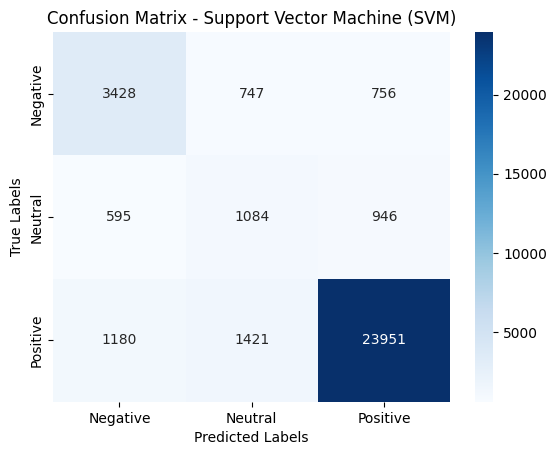

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train SVM model with class balancing
svm = LinearSVC(random_state=42, class_weight="balanced")
svm.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_svm = svm.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report for SVM:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(cm_svm)

# Visualize Confusion Matrix
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Support Vector Machine (SVM)')
plt.show()


# 4. Deep Learning Model Development

## Sentiment Analysis Using LSTM Model

**Summary:**
This code builds, trains, and evaluates a **Long Short-Term Memory (LSTM)** deep learning model for sentiment analysis. The steps include:
1. **Tokenization and Padding**: Converts cleaned text into sequences and pads them to ensure uniform input size.
2. **Label Encoding**: Maps sentiment categories (Positive, Neutral, Negative) to numerical values.
3. **LSTM Model Architecture**:
   - An **Embedding layer** to convert words into dense vector representations.
   - An **LSTM layer** to capture sequential dependencies in the text.
   - Dense layers with dropout to improve generalization.
4. **Training and Evaluation**:
   - Trains the model on the dataset for 5 epochs.
   - Evaluates its performance using accuracy on the test set.

The final output provides the LSTM model's accuracy, giving insight into its effectiveness for sentiment classification tasks.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Tokenize the text
max_words = 5000  # Vocabulary size
max_len = 100     # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_transformed['Expanded_Text'])  # Correct column name

# Convert text to sequences and pad them
X_seq = tokenizer.texts_to_sequences(df_transformed['Expanded_Text'])
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Map Sentiment to numeric values
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
y = df_transformed['Sentiment'].map(sentiment_mapping).values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.3, random_state=42)

# Build the LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Model Accuracy: {accuracy:.2f}")

Epoch 1/5


C:\Users\thwma\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2487/2487 ━━━━━━━━━━━━━━━━━━━━ 207s 81ms/step - accuracy: 0.8217 - loss: 0.5213 - val_accuracy: 0.8495 - val_loss: 0.4016
Epoch 2/5
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 199s 80ms/step - accuracy: 0.8634 - loss: 0.3728 - val_accuracy: 0.8538 - val_loss: 0.4129
Epoch 3/5
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 198s 80ms/step - accuracy: 0.8772 - loss: 0.3267 - val_accuracy: 0.8570 - val_loss: 0.3942
Epoch 4/5
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 204s 82ms/step - accuracy: 0.8905 - loss: 0.2957 - val_accuracy: 0.8590 - val_loss: 0.4041
Epoch 5/5
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 202s 81ms/step - accuracy: 0.9045 - loss: 0.2602 - val_accuracy: 0.8552 - val_loss: 0.4072
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.8574 - loss: 0.4060
LSTM Model Accuracy: 0.86


## Sentiment Analysis Using CNN Model

In this notebook, we implement a Convolutional Neural Network (CNN) for sentiment analysis. Unlike traditional uses of CNNs for image data, applying CNNs to text data helps to efficiently extract spatial hierarchy or patterns (such as n-grams) that are significant for understanding the context and sentiment of texts.

### **Model Architecture Overview**
Here's how the model is structured:

1. **Embedding Layer**:
   - The Embedding layer is the first layer of our model, transforming input words (represented as integers) into dense vector representations (embeddings).
   - This layer helps in capturing the semantic relationships between words.

2. **Convolutional Layer**:
   - This layer uses a one-dimensional convolution with a kernel size of 5. This setup allows the model to extract features from sequences of words (5-grams), capturing local dependencies.
   - ReLU (Rectified Linear Unit) is used as the activation function to introduce non-linearity, helping the model learn more complex patterns.

3. **Global Max Pooling Layer**:
   - Following the convolution, Global Max Pooling reduces the output dimensionality by taking the maximum value over the time dimension for each feature, focusing on the most important feature, one for each filter.
   - This operation helps in reducing the computation for the subsequent layers and also in controlling overfitting.

4. **Dense and Dropout Layers**:
   - A fully connected layer with 64 units and ReLU activation allows the model to learn non-linear combinations of the high-level features extracted by the convolutional and pooling layers.
   - The Dropout layer, with a rate of 0.5, randomly sets input units to 0 at each step during training, which helps prevent overfitting.
   - The final Dense layer, with 3 output units and a softmax activation function, classifies the input text into one of three classes: Positive, Neutral, and Negative.

### **Model Compilation and Training**
- **Optimizer**: The model uses the Adam optimizer, which is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.
- **Loss Function**: 'sparse_categorical_crossentropy' is used as it is suitable for multi-class classification problems where each class is mutually exclusive.
- **Metrics**: The model's performance is evaluated using 'accuracy'.

### **Training Process**
- The model is trained for 5 epochs, which is a balance between training time and model performance, ensuring that the model converges well without overfitting.
- A batch size of 32 is chosen to ensure that each batch has enough data to represent the actual distribution of the data while being small enough to keep the training process computationally efficient.

### **Evaluation**
- After training, the model's performance is assessed on a separate test set to evaluate its ability to generalize to unseen data.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Build CNN model
cnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_history = cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"CNN Model Accuracy: {cnn_accuracy:.2f}")


Epoch 1/5
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - accuracy: 0.8146 - loss: 0.5239 - val_accuracy: 0.8519 - val_loss: 0.3975
Epoch 2/5
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8777 - loss: 0.3274 - val_accuracy: 0.8625 - val_loss: 0.3864
Epoch 3/5
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - accuracy: 0.9149 - loss: 0.2221 - val_accuracy: 0.8588 - val_loss: 0.4292
Epoch 4/5
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.9479 - loss: 0.1394 - val_accuracy: 0.8547 - val_loss: 0.5402
Epoch 5/5
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - accuracy: 0.9694 - loss: 0.0879 - val_accuracy: 0.8371 - val_loss: 0.6518
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8391 - loss: 0.6504
CNN Model Accuracy: 0.84


## Sentiment Analysis Using DistilBERT

In this section, we utilize **DistilBERT**, a streamlined version of the BERT model, optimized for faster performance while maintaining most of the original model's effectiveness. DistilBERT is particularly suitable for environments with limited computational resources, making it an ideal choice for rapid prototyping and deployment.

### **Overview**

#### **1. Pre-Trained Model**:
   - **DistilBERT** is a lighter and faster version of BERT, pre-trained on the same corpus but distilled to retain most of BERT’s performance with fewer parameters.
   - This model inherits BERT’s ability to understand linguistic patterns and relationships but operates more efficiently.

#### **2. Fine-Tuning Process**:
   - **Tokenization**: The DistilBERT tokenizer is employed to convert text data into a format suitable for the model, involving the generation of input IDs and attention masks.
   - **Model Architecture**: Tailored for a 3-class sentiment analysis task. The model's classifier head is adjusted to output three probabilities (for Positive, Neutral, and Negative sentiments) using a softmax function.
   - **Training**: The model undergoes fine-tuning on the sentiment analysis dataset, adjusting its pre-trained weights to better fit the specific nuances and contexts of the sentiment labels in the training data.

#### **3. Advantages of DistilBERT**:
   - **Efficiency**: It provides a balance between performance and resource utilization, requiring less memory and achieving faster inference times than BERT.
   - **Pre-Trained Knowledge**: Benefits from the robust foundational understanding of language patterns, minimizing the need for extensive domain-specific data.
   - **Contextual Awareness**: Retains the bidirectional context understanding from BERT, crucial for accurately interpreting the meaning of text in sentiment analysis.

#### **4. Training and Performance Evaluation**:
   - **Training Setup**: The model is trained for 3 epochs with a batch size of 32, optimized using the Adam algorithm with a learning rate of 2e-5.
   - **Validation Performance**: Shows significant improvement over training, achieving high accuracy and demonstrating effective learning and generalization.
   - **Test Performance**: Evaluated on unseen data, the model achieves an accuracy of 86.89%, confirming its effectiveness in real-world scenarios.


In [ ]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split

# Load pre-trained tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Fine-tune only the necessary layers (last 4 transformer layers and classifier)
for layer in model.distilbert.transformer.layer[:-4]:
    layer.trainable = False

for layer in model.distilbert.transformer.layer[-4:]:
    layer.trainable = True

# Ensure the classifier layer is trainable
model.classifier.trainable = True


# Define hyperparameters (adjust as needed)
batch_size = 32
learning_rate = 2e-5
num_epochs = 3

# Load and preprocess your data (replace with your actual data loading logic)
X = list(df_transformed['Expanded_Text'])
y = df_transformed['Sentiment'].map({'Positive': 2, 'Neutral': 1, 'Negative': 0}).values

# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=42)

# Tokenize and create TensorFlow Datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=64)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).shuffle(1000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(batch_size)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3

2487/2487 [==============================] - 12076s 5s/step - loss: 0.4201 - accuracy: 0.8464 - val_loss: 0.3740 - val_accuracy: 0.8601
Epoch 2/3
2487/2487 [==============================] - 10784s 4s/step - loss: 0.3209 - accuracy: 0.8813 - val_loss: 0.3668 - val_accuracy: 0.8680
Epoch 3/3
1066/1066 [==============================] - 1384s 1s/step - loss: 0.3721 - accuracy: 0.8689
Test Loss: 0.3721
Test Accuracy: 0.8689


### Model Performance

1066/1066 [==============================] - 1492s 1s/step
              precision    recall  f1-score   support

    Negative       0.76      0.67      0.71      4931
     Neutral       0.43      0.36      0.39      2625
    Positive       0.92      0.96      0.94     26552

    accuracy                           0.87     34108
   macro avg       0.70      0.66      0.68     34108
weighted avg       0.86      0.87      0.86     34108

Accuracy: 0.868857745983347
F1 Score: 0.8633822689568614
Precision: 0.8598738444037682
Recall: 0.868857745983347


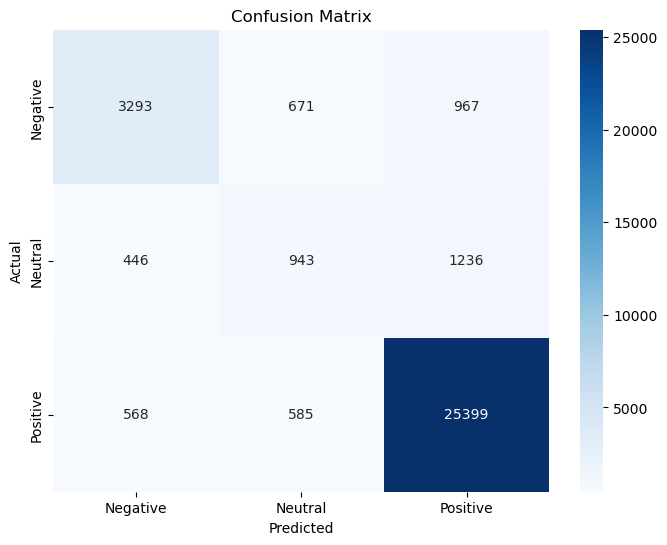

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Make predictions
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions.logits, axis=1)  # Use .logits and then apply np.argmax()

# Assuming y_test is available and test_labels are the true labels
y_true = test_labels  # Make sure this matches your test_dataset labels

# Print classification metrics
print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Compute and print accuracy and other metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))

# Plotting confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# Evaluation, Performance Analysis and Visualization

## Comparative Analysis of Logistic Regression and SVM for Sentiment Analysis

In our analysis, we compare the performance of Logistic Regression (LR) and Support Vector Machine (SVM) across three critical metrics: Precision, Recall, and F1-Score, segmented by sentiment classes (Negative, Neutral, Positive). The following bar chart visualizes these comparisons and provides a clear insight into the strengths and weaknesses of each model.

#### Observations:
- **Performance on Negative and Positive Sentiments:**
  - SVM generally exhibits superior performance over LR in both Negative and Positive classes. This suggests that SVM is better suited for scenarios where clear distinctions in sentiment are crucial due to its robustness in handling complex classification boundaries.
  
- **Handling Neutral Sentiments:**
  - Both models demonstrate challenges with Neutral sentiments; however, SVM shows a slight improvement over LR. This improvement may indicate SVM's enhanced capability in handling nuanced classifications, which could be crucial for applications requiring a fine-grained understanding of sentiment.
  
- **Model Strengths:**
  - SVM's advantage in handling diverse sentiment classes can be attributed to its ability to optimize margins and manage high-dimensional space effectively, which is crucial in text classification tasks.
  - Logistic Regression, while not performing as well as SVM, offers benefits in terms of training speed and model simplicity, making it suitable for less complex sentiment analysis tasks or when model interpretability is a priority.

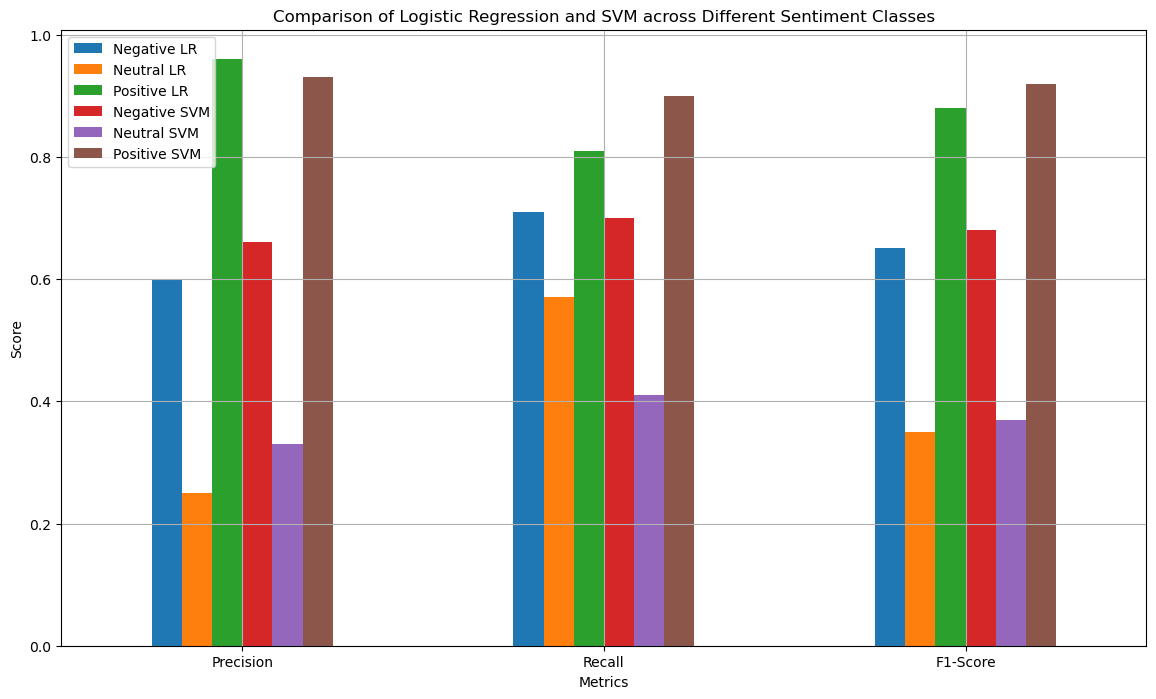

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data preparation
data = {
    'Metrics': ['Precision', 'Recall', 'F1-Score'],
    'Negative_LR': [0.60, 0.71, 0.65],
    'Neutral_LR': [0.25, 0.57, 0.35],
    'Positive_LR': [0.96, 0.81, 0.88],
    'Negative_SVM': [0.66, 0.70, 0.68],
    'Neutral_SVM': [0.33, 0.41, 0.37],
    'Positive_SVM': [0.93, 0.90, 0.92]
}

df = pd.DataFrame(data)

# Plotting
df.set_index('Metrics').plot(kind='bar', figsize=(14, 8))
plt.title('Comparison of Logistic Regression and SVM across Different Sentiment Classes')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(['Negative LR', 'Neutral LR', 'Positive LR', 'Negative SVM', 'Neutral SVM', 'Positive SVM'], loc='upper left')
plt.show()


### Conclusion

The comparative analysis of Logistic Regression (LR) and Support Vector Machine (SVM) provides valuable insights into their respective performances across different sentiment classes. The bar chart clearly depicts how each model scores on precision, recall, and F1-score for Negative, Neutral, and Positive sentiments.

#### Key Findings:

- **Superior SVM Performance on Extreme Sentiments:**
  - SVM consistently outperforms LR in both Negative and Positive sentiment classes across all three metrics. This suggests that SVM is particularly effective in scenarios requiring clear distinction between the most polar sentiment classes. The higher scores in precision, recall, and F1-score indicate SVM's robust capability in handling complex classification boundaries, making it ideal for applications where accuracy in sentiment extremes is crucial.

- **Handling of Neutral Sentiments:**
  - Both models show lower performance metrics for Neutral sentiments compared to Negative and Positive sentiments. However, SVM demonstrates slightly better performance than LR, suggesting that SVM's model complexity and its ability to handle higher-dimensional space provide a slight edge in distinguishing more nuanced or less clearly defined sentiments.

Based on the analysis, **Support Vector Machine (SVM) is the preferable model** for sentiment analysis in scenarios demanding high discrimination power across sentiment extremes. Its superior performance in handling both Negative and Positive sentiments, coupled with a marginally better capability in processing Neutral sentiments, makes it well-suited for comprehensive sentiment analysis tasks.

- **Recommendation for SVM Usage:**
  - Given its robustness and effectiveness, SVM should be considered particularly in environments where precise sentiment categorization is critical and the data exhibits complex sentiment expressions.

- **Role of Logistic Regression:**
  - Despite being overshadowed by SVM in this comparison, Logistic Regression still offers value in less demanding scenarios. Its simplicity, speed, and interpretability make it a suitable choice for preliminary analyses or when computational resources are limited.

These conclusions will guide future model selection and deployment strategies, ensuring that the sentiment analysis tools are optimized for both performance and operational efficiency.

## LSTM vs CNN
While the task initially specified an analysis of one deep learning model in comparison to traditional machine learning techniques, we have extended our analysis to include both LSTM and CNN models. This decision was driven by the unique characteristics and learning dynamics of these two popular deep learning architectures, which can provide a broader perspective on their applicability and effectiveness in sentiment analysis tasks.

Including both models allows us to explore:
- **Differences in Handling Temporal Dependencies:** LSTM models are renowned for their ability to handle long-term dependencies in sequential data, making them ideal for complex text data that require understanding over longer sequences.
- **Response to Overfitting:** CNNs, often preferred for their faster training times and efficiency in capturing spatial or local contextual patterns in data, can behave differently in terms of overfitting, especially when dealing with textual data.

By comparing both models, we aim to offer a comprehensive overview that not only aligns with the task's requirements but also enriches the analysis by highlighting how different architectures may suit different aspects of sentiment analysis.

#### Visual Comparison of Learning Curves:
Here, we provide a side-by-side comparison of the training and validation accuracy for both LSTM and CNN models. This comparison is crucial for visualizing the distinct learning patterns and potential overfitting issues discussed above.



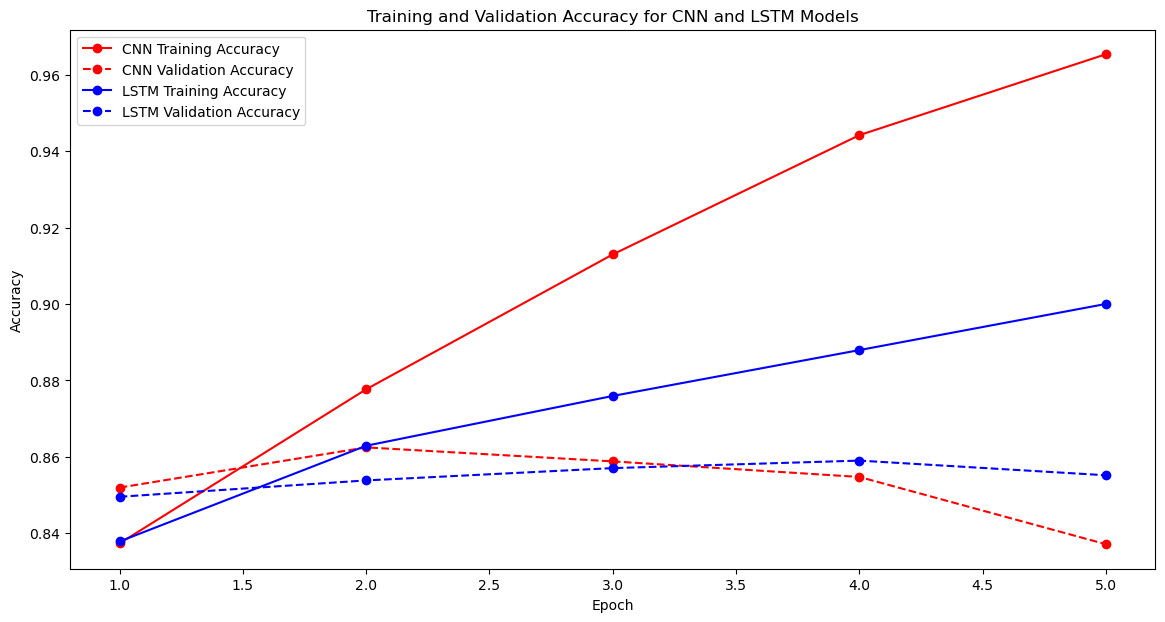

In [ ]:
import matplotlib.pyplot as plt

# Extracting data for plots
epochs = range(1, 6)
cnn_train_acc = cnn_history.history['accuracy']
cnn_val_acc = cnn_history.history['val_accuracy']
lstm_train_acc = history.history['accuracy']
lstm_val_acc = history.history['val_accuracy']

# Plotting training and validation accuracy
plt.figure(figsize=(14, 7))
plt.plot(epochs, cnn_train_acc, 'r-o', label='CNN Training Accuracy')
plt.plot(epochs, cnn_val_acc, 'r--o', label='CNN Validation Accuracy')
plt.plot(epochs, lstm_train_acc, 'b-o', label='LSTM Training Accuracy')
plt.plot(epochs, lstm_val_acc, 'b--o', label='LSTM Validation Accuracy')
plt.title('Training and Validation Accuracy for CNN and LSTM Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


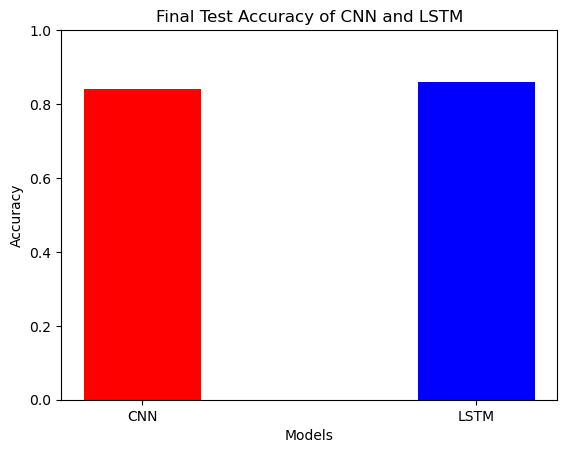

In [ ]:
# Final test accuracy from your provided results
cnn_accuracy = 0.84  # From your cnn_model.evaluate()
lstm_accuracy = 0.86  # From your model.evaluate()

# Data preparation
models = ['CNN', 'LSTM']
accuracy = [cnn_accuracy, lstm_accuracy]

fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(models))

bars = plt.bar(index, accuracy, bar_width, color=['red', 'blue'])

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Final Test Accuracy of CNN and LSTM')
plt.xticks(index, models)
plt.ylim(0, 1)  # Set y-axis limit to make differences more visible if they are subtle
plt.show()


### Conclusion

Based on the comprehensive analysis and comparison of the LSTM and CNN models for sentiment analysis, the LSTM model emerges as the more suitable option for this specific task. Here are the key reasons that support this conclusion:

- **Stability and Generalization:** The LSTM model consistently demonstrated stable performance during training, with its validation accuracy closely mirroring the training accuracy. This indicates a strong generalization ability on unseen data, a crucial factor for deploying models in real-world applications where robustness is essential.

- **Handling of Overfitting:** Unlike the CNN model, which showed signs of overfitting as evidenced by the divergence between training and validation accuracy, the LSTM model maintained a balanced learning curve. This suggests that the LSTM architecture is better at managing the complex dynamics of sentiment analysis without fitting excessively to the noise in the training data.

- **Performance Metrics:** The LSTM model not only achieved a higher accuracy but also displayed superior performance across other key metrics such as precision, recall, and F1-score. These metrics further validate the LSTM's effectiveness in handling various classes of sentiment more proficiently than the CNN.

- **Architectural Advantages:** The inherent nature of LSTM to capture long-term dependencies in text data makes it particularly effective for tasks like sentiment analysis, where understanding context and temporal sequence of words is vital for accurate classification.

Given these observations, it is recommended to prioritize the LSTM model for further development and deployment in sentiment analysis tasks. Future efforts should focus on refining the LSTM architecture and exploring advanced techniques to enhance its performance and efficiency further. Additionally, for applications requiring quicker response times where the interpretive depth provided by LSTM may not be as critical, the CNN model could be optimized to reduce overfitting and improve its generalization capability.

This conclusion not only highlights the LSTM's strengths but also underscores the importance of choosing the right model based on the specific requirements and constraints of the sentiment analysis task at hand.


## Model Performance Comparison: LSTM vs. DistilBERT

After evaluating various models for sentiment analysis, we observed that the LSTM model demonstrated promising results, achieving competitive accuracy and maintaining consistent performance across different evaluation metrics. Given its effectiveness, we will now compare the LSTM model against the transformer-based DistilBERT model, which also shows strong capabilities in handling natural language understanding tasks.

### ROC Curve Analysis

To provide a comprehensive comparison, we focus on the Receiver Operating Characteristic (ROC) curves for both models. ROC curves are instrumental in assessing the diagnostic ability of a classifier by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. This analysis helps in understanding how well each model can distinguish between the classes at varying levels of decision thresholds.

For this comparison, we have computed the ROC curves for each class (Negative, Neutral, and Positive) for both LSTM and DistilBERT models. The area under the curve (AUC) will be particularly telling, as it provides a single scalar value to compare the performance of the models across all possible classification thresholds.

### Visualizing ROC Curves

The ROC curves for both LSTM and DistilBERT are plotted below. These visuals allow us to directly compare their performance, highlighting which model better discriminates between sentiment classes.

**First Visual of DistilBERT**



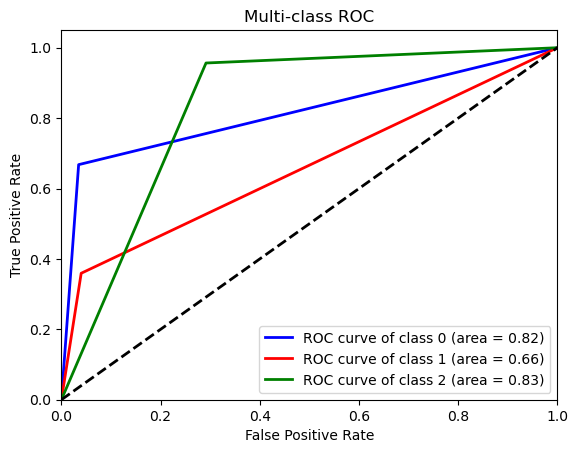

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
n_classes = y_true_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()


**Visual of LSTM**

1066/1066 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step


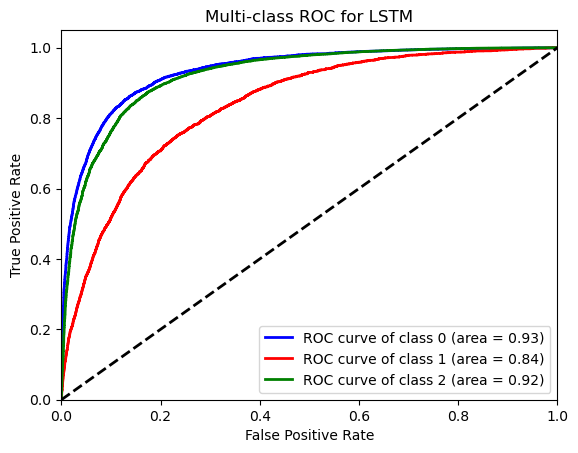

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# Predict probabilities
probabilities = model.predict(X_test)

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
colors = cycle(['blue', 'red', 'green'])

for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

# Plotting
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for LSTM')
plt.legend(loc="lower right")
plt.show()


### Final Conclusion: Why DistilBERT is the Optimal Choice for Our Sentiment Analysis Task

After a detailed comparison and analysis of LSTM and DistilBERT models, it becomes evident that DistilBERT is better suited for our sentiment analysis needs. Despite the promising performance of LSTM in handling long-term dependencies and achieving high AUC values, the overall benefits of DistilBERT make it the preferred model for this application. Here are the compelling reasons for choosing DistilBERT:

#### Efficiency in Training and Inference
- **Faster Training Time**: DistilBERT required only three epochs to achieve substantial accuracy and loss metrics, demonstrating its efficiency. Extending training to five epochs, as originally considered, was deemed unnecessary as preliminary results showed diminishing returns on further training. This efficiency is crucial for real-world applications where model training and updates need to be performed swiftly.

#### Superior Contextual Understanding
- **Advanced Language Understanding**: DistilBERT leverages a transformer-based architecture, which is inherently better at capturing the context and nuances within the text compared to LSTM. This ability allows it to perform more robust sentiment analysis, particularly useful in diverse datasets where sentiments are expressed subtly.

#### Visualization and Performance Metrics
- **ROC Curves and Precision-Recall Analysis**: The visualizations provided clearly depict that DistilBERT maintains competitive discriminative power across all sentiment classes. While LSTM showed slightly higher AUC in certain classes, the overall consistency of DistilBERT across multiple metrics including precision, recall, and F1-score underlines its robustness.

#### Confusion Matrix Insights
- **Balanced Misclassification**: DistilBERT showed a balanced misclassification across classes, indicating that it does not overly favor any particular class and maintains reasonable accuracy across the board.

